## Importing Libraries

In [5]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D, Input
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

#### Installing Keras Tuner

In [3]:
# !pip install keras-tuner --upgrade

     ------------------------------------ 176.1/176.1 kB 424.2 kB/s eta 0:00:00


In [2]:
import keras_tuner as kt

# Data preprocessing
#### check data_processing.py

In [1]:
from data_processing import process_data

dataset_path = r'G:\BTP\dataset\labelled frames'

train_images, labels = process_data(dataset_path)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:11<00:00, 14.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [00:31<00:00,  9.33it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:03<00:00, 16.72it/s]


In [2]:
train_images.shape

(835, 128, 128, 3)

##### Spliting the data into train-test(val) sets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_images, labels, test_size=0.2,random_state=123)

X_train.shape, X_test.shape

((668, 128, 128, 3), (167, 128, 128, 3))

# Model Architecture

### Loss and Metrics

In [8]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [9]:
IoU_loss = sm.losses.JaccardLoss()
focal_loss = sm.losses.BinaryFocalLoss()## for minority category
total_loss = (0.5 *IoU_loss) + (0.5 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

##### Model Architecture

In [10]:
input_shape = X_train.shape[1:]
input_shape

(128, 128, 3)

In [52]:
def create_model(hp,input_shape=input_shape, pool_size=(2,2)):
    # hp - hyperparamerers
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(BatchNormalization(input_shape=input_shape))
    
    num_blocks = hp.Int('num_blocks', 3,5)
    
    for i in range(num_blocks):
        hp_filters=hp.Int('filters_'+ str(i+1), min_value=8, max_value=64)
        hp_kernel=hp.Choice('kernel_'+ str(i+1), values=[3,5])
        model.add(Conv2D(hp_filters, (hp_kernel,hp_kernel), padding='same', activation='relu', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(hp.Choice('dropout_'+ str(i+1), values=[0.0, 0.2,0.3,0.4,0.5])))
  
    for i in range(num_blocks):                         
        model.add(UpSampling2D(size=(2, 2)))
        hp_filters=hp.Int('filters_D_'+ str(i+1),  min_value=8, max_value=64)
        hp_kernel=hp.Choice('kernel_D_'+ str(i+1), values=[3,5])
        # Deconv 1
        model.add(Conv2DTranspose(hp_filters, (hp_kernel,hp_kernel), padding='same', activation = 'relu', kernel_initializer='he_uniform'))
        model.add(Dropout(hp.Choice('dropout_D'+ str(i+1), values=[0.0, 0.2,0.3,0.4,0.5])))


    hp_kernel=hp.Choice('kernel_D_'+ str(num_blocks+1), values=[3,5])
    model.add(Conv2DTranspose(1, (hp_kernel,hp_kernel), padding='same', activation = 'sigmoid', kernel_initializer='he_uniform'))
    
    
    optimizer= Adam(learning_rate = hp.Float('learning_rate', 1e-4,  1e-2))
    
    model.compile(optimizer=optimizer, loss    = total_loss, metrics =metrics)
    #model.compile(optimizer=optimizer, loss    = total_loss ,metrics = [tf.keras.metrics.BinaryIoU(target_class_ids=[0], threshold=0.5)])
    
    return model 


# Tuning through Keras tuner

In [53]:
import random
random_seed =random.seed(0)

In [54]:
class MyTuner(kt.tuners.BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32,64)
        #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30,steps=1)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [55]:
tuner = MyTuner(
    create_model,
    seed=random_seed,
    objective='val_loss',
    max_trials=10,
    overwrite=True,
    directory='my_project_btp',
)

# tuner = kt.tuners.BayesianOptimization(
#     create_model,
#     seed=random_seed,
#     objective='val_loss',
#     max_trials=5,
#     overwrite=True,
#     directory='my_project_btp',
# )

In [56]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs = 10, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])

Trial 10 Complete [00h 03m 29s]
val_loss: 0.16307970881462097

Best val_loss So Far: 0.1434887796640396
Total elapsed time: 00h 39m 53s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [57]:
best_mlp_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters.values

Best Hyper-parameters


{'num_blocks': 5,
 'filters_1': 8,
 'kernel_1': 3,
 'dropout_1': 0.0,
 'filters_2': 22,
 'kernel_2': 3,
 'dropout_2': 0.2,
 'filters_3': 37,
 'kernel_3': 3,
 'dropout_3': 0.5,
 'filters_4': 46,
 'kernel_4': 3,
 'dropout_4': 0.3,
 'filters_5': 63,
 'kernel_5': 3,
 'dropout_5': 0.0,
 'filters_D_1': 59,
 'kernel_D_1': 3,
 'dropout_D1': 0.3,
 'filters_D_2': 48,
 'kernel_D_2': 3,
 'dropout_D2': 0.3,
 'filters_D_3': 33,
 'kernel_D_3': 3,
 'dropout_D3': 0.2,
 'filters_D_4': 19,
 'kernel_D_4': 3,
 'dropout_D4': 0.0,
 'filters_D_5': 10,
 'kernel_D_5': 3,
 'dropout_D5': 0.0,
 'kernel_D_6': 3,
 'learning_rate': 0.0007554290444470892,
 'batch_size': 41}

In [58]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 22)        1606      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 22)       0

## Model Training

In [63]:
batch_size=41
history = best_model.fit(X_train, y_train,
              validation_data  =(X_test, y_test),
              epochs           = 50,
              validation_steps = len(X_test)/batch_size,  
              steps_per_epoch  = len(X_train)/batch_size)


Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.1540 - iou_score: 0.7896 - f1-score: 0.8823 - val_loss: 0.1317 - val_iou_score: 0.8313 - val_f1-score: 0.9079
Epoch 2/50
16/16 [==============================] - 20s 1s/step - loss: 0.1443 - iou_score: 0.7999 - f1-score: 0.8887 - val_loss: 0.1220 - val_iou_score: 0.8498 - val_f1-score: 0.9187
Epoch 3/50
16/16 [==============================] - 18s 1s/step - loss: 0.1377 - iou_score: 0.8076 - f1-score: 0.8935 - val_loss: 0.1180 - val_iou_score: 0.8526 - val_f1-score: 0.9204
Epoch 4/50
16/16 [==============================] - 18s 1s/step - loss: 0.1298 - iou_score: 0.8199 - f1-score: 0.9010 - val_loss: 0.1084 - val_iou_score: 0.8651 - val_f1-score: 0.9276
Epoch 5/50
16/16 [==============================] - 18s 1s/step - loss: 0.1235 - iou_score: 0.8298 - f1-score: 0.9069 - val_loss: 0.1043 - val_iou_score: 0.8693 - val_f1-score: 0.9300
Epoch 6/50
16/16 [==============================] - 18s 1s/step - loss: 0.1207 -

In [33]:
print('Train loss: ',0.0604)
print('Train IoU: ',0.9148)
print('Train F1 Score: ', 0.9148)

Train loss:  0.0604
Train IoU:  0.9148
Train F1 Score:  0.9148


In [64]:
best_model.save('best_model.h5')

#### Plot training & validation results 

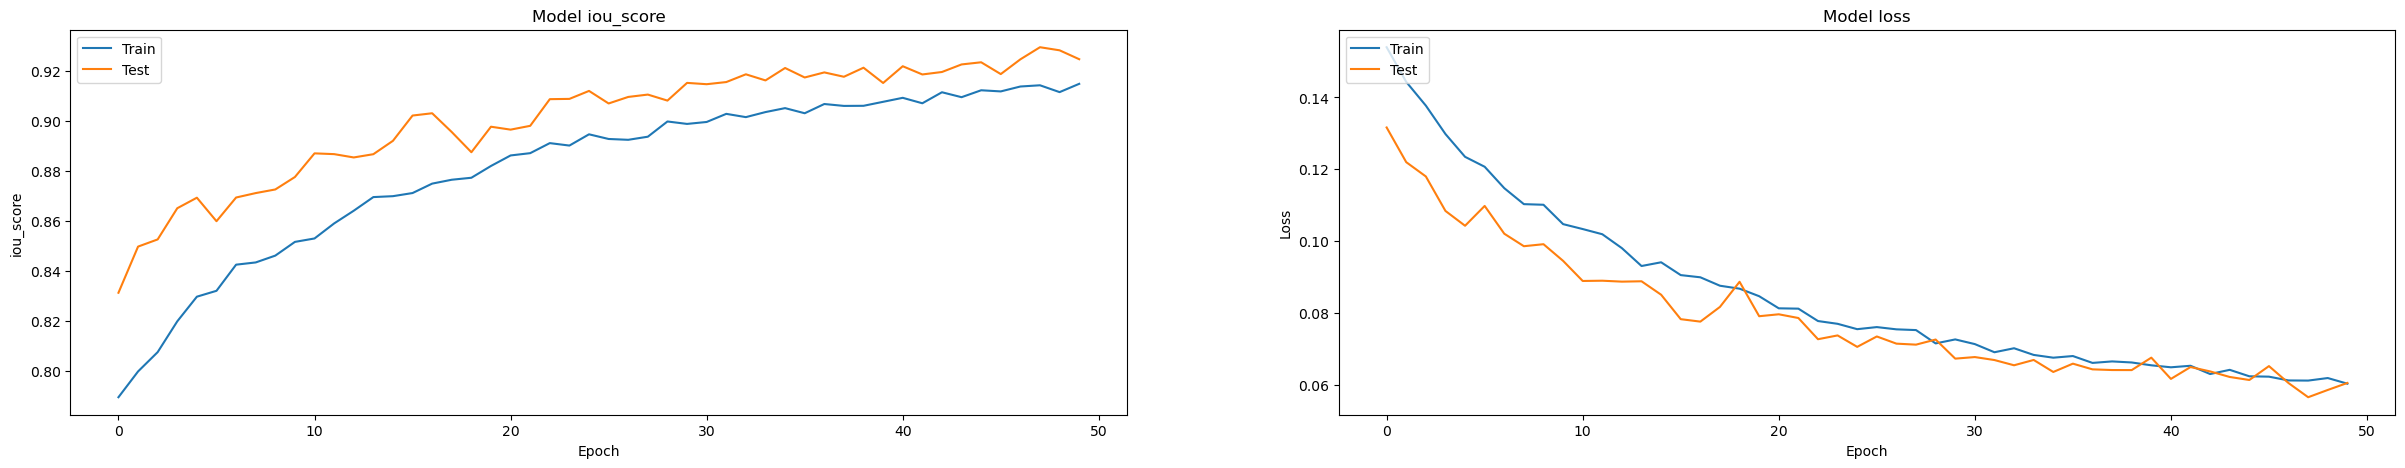

In [65]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Test Data Evaluation

In [29]:
from keras.models import load_model

model = load_model('best_model_manipu_50epo.h5', compile=False)

optimizer= Adam(learning_rate = 0.0007554290444470892)

model.compile(optimizer=optimizer, loss = total_loss, metrics =metrics)

In [30]:
test_loss, test_IoU, test_F1score = model.evaluate(X_test,y_test)

6/6 [==============================] - 2s 234ms/step - loss: 0.0574 - iou_score: 0.9235 - f1-score: 0.9602


In [31]:
print('Test loss: ',test_loss)
print('Test IoU: ',test_IoU)
print('Test F1 Score: ', test_F1score)

Test loss:  0.057438429445028305
Test IoU:  0.9235376715660095
Test F1 Score:  0.960240364074707


### Visualization of Result Images

In [34]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

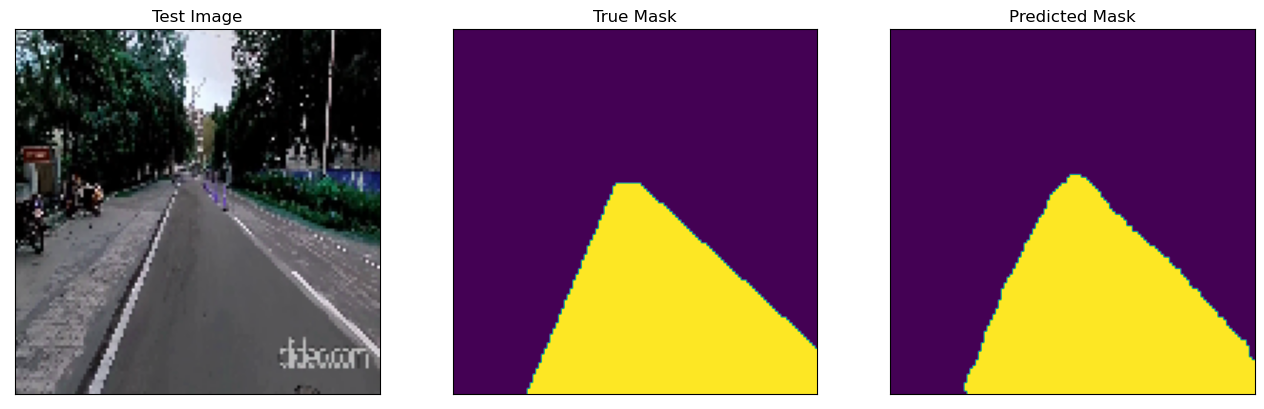

In [35]:
test_img = X_test[0]

ground_truth = y_test[0]

test_img_input = np.expand_dims(test_img, 0)

prediction = model.predict(test_img_input, verbose=0)
prediction = prediction[0,:,:,0] > 0.5
visualize(
    Test_Image = test_img,
    True_Mask = ground_truth,
    Predicted_Mask = prediction
)

